# MT3D-USGS: Examples 1a through 1z

We will use a 1D test problem to explore some of the b

In [40]:
# Some needed libraries
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy


First, create a 1D MODFLOW model for generating a flow field for MT3D-USGS to work with.  We will store the MODFLOW model in an object called 'mf'. 
* A model name of "1D" will be the name given to all MODFLOW input files.
* 1 Row x 100 Columns x 1 Layer x 2 stress periods
* Will be using version: 'mfnwt', or MODFLOW-NWT

In [41]:
modelpth = os.path.join('flopy')
modelname = '1D'
mfexe = 'mfnwt'
mtexe = 'mt3dusgs'

if platform.system() == 'Windows':
    mfexe += '.exe'
    mtexe += '.exe'

# Make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.mkdir(modelpth)

# Instantiate MODFLOW object in flopy
mf = flopy.modflow.Modflow(modelname=modelname, exe_name=mfexe, model_ws=modelpth, version='mfnwt')


### Define model dimensions

In [46]:
# Set up model discretization

Lx = 1000.0 
Ly = 10.0
nrow = 1
ncol = 100
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(np.linspace(delr / 2, xmax - delr / 2, ncol),    
                   np.linspace(ymax - delc / 2, 0 + delc / 2, nrow))


### Instantiate output control (oc) package for MODFLOW-NWT

In [47]:
# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf)     

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


### Instantiate solver package for MODFLOW-NWT

In [48]:
# Will use the Newton-Rhapson Solver.  Creating a flopy nwt package object...

headtol = 1.0E-4 
fluxtol = 5      
maxiterout = 5000
thickfact = 1E-06
linmeth = 2      
iprnwt = 1       
ibotav = 1       

nwt = flopy.modflow.ModflowNwt(mf, headtol=headtol, fluxtol=fluxtol, maxiterout=maxiterout,
                               thickfact=thickfact, linmeth=linmeth, iprnwt=iprnwt, ibotav=ibotav,
                               options='SIMPLE')


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfnwt.ModflowNwt'> <class 'flopy.modflow.mfnwt.ModflowNwt'>
replacing existing Package...


### Instantiate discretization (DIS) package for MODFLOW-NWT

In [49]:
grndElv = 5
botm = 0.0

# Stress period info
Steady = [False, False]
nstp = [1, 1]
nper = 2
tsmult = 1.
perlen = [100,3550]

# Create the discretization object
# itmuni = 4 (days); lenuni = 1 (feet)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=nper, delr=delr, delc=delc,     
                               top=grndElv, botm=botm, laycbd=0, itmuni=4, lenuni=2,
                               steady=Steady, nstp=nstp, tsmult=tsmult, perlen=perlen) 


### Instantiate upstream weighting (UPW) flow package for MODFLOW-NWT

In [50]:
# First line of UPW input is: IUPWCB HDRY NPUPW IPHDRY 
hdry = -1.00e+30
iphdry = 0

# Next variables are: LAYTYP, LAYAVG, CHANI, LAYVKA, LAYWET
laytyp = 1          # >0: convertible
layavg = 0          #  0: harmonic mean
chani = 1.0         # >0: CHANI is the horizontal anisotropy for the entire layer
layvka = 0          # =0: indicates VKA is vertical hydraulic conductivity
laywet = 0          # Always set equal to zero in UPW package
hk = 20
# hani = 1          # Not needed because CHANI > 1
vka = 0.5           # Is equal to vert. K b/c LAYVKA = 0
ss = 0.000001
sy = 0.20

upw = flopy.modflow.ModflowUpw(mf, laytyp=laytyp, layavg=layavg, chani=chani, layvka=layvka,
                               laywet=laywet, ipakcb=53, hdry=hdry, iphdry=iphdry, hk=hk, 
                               vka=vka, ss=ss, sy=sy)


### Instantiate basic (BAS or BA6) package for MODFLOW-NWT

In [51]:
ibnd1 = np.ones((nrow, ncol))
sthd1 = np.ones((nrow, ncol)) * 10.

hdry = 999.0

bas = flopy.modflow.ModflowBas(mf, ibound=ibnd1, hnoflo=hdry, strt=sthd1)

### Instantiate general head boundary (GHB) package for MODFLOW-NWT

In [52]:
# GHB boundaries are use to create a gradient driving flow from left ot right

leftside_hd  = 40.
rightside_hd = 10.
cond         = 100.
elev_slp     = (308.82281 - 298.83649) / (ncol - 1)

sp = []
sp.append([nlay - 1, nrow - 1, 0, leftside_hd, cond])
sp.append([nlay - 1, nrow - 1, ncol - 1, rightside_hd, cond])

ghb = flopy.modflow.ModflowGhb(mf, stress_period_data = sp)


### Instantiate linkage with mass transport routing (LMT) package for MODFLOW-NWT (generates linker file)

In [53]:
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='1D.ftl', output_file_header='extended',
                               output_file_format='formatted')


# Switching gears to MT3D-USGS

\begin{equation*}
\bar{C} = K_f C^\alpha
\end{equation*}

\begin{equation*}
\frac{\partial \bar{C}}{\partial C} = \alpha K_f C^{\alpha - 1}
\end{equation*}

Text(0,0.5,'Sorbed Concentration, $\\bar{C}$')

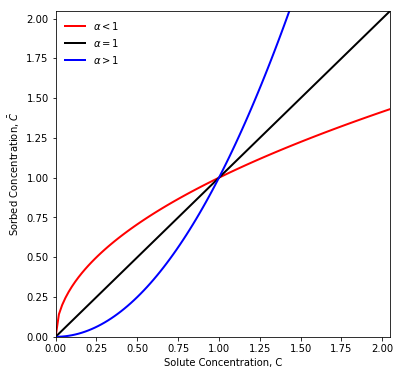

In [38]:
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def calc_sorb_C(x, a=1, Kf=1):
    y = []
    
    for i in x:
        sorb_C = Kf*i**(a)
        y.append(sorb_C)
        
    y = np.array(y)
    return y
        
solute_C = np.arange(0.0,2.1,0.02)
sorbed_C_lt = calc_sorb_C(solute_C, a=0.5, Kf=1)
sorbed_C_eq = calc_sorb_C(solute_C, a=1, Kf=1)
sorbed_C_gt = calc_sorb_C(solute_C, a=2, Kf=1)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.25, hspace=0.25)

ax = fig.add_subplot(1, 1, 1)
ax.plot(solute_C, sorbed_C_lt, linewidth=2, color='red', label=r'$\alpha < 1$')
ax.plot(solute_C, sorbed_C_eq, linewidth=2, color='black', label=r'$\alpha = 1$')
ax.plot(solute_C, sorbed_C_gt, linewidth=2, color='blue', label=r'$\alpha > 1$')
ax.set_xlim([0,2.05])
ax.set_ylim([0,2.05])

leg = ax.legend(loc='upper left')
leg.draw_frame(False)
ax.set_xlabel('Solute Concentration, C')
plt.ylabel(r'Sorbed Concentration, $\bar{C}$')


For 